In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
# Tokenization and Stopword removal
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/Pi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


# 1. Data Cleaning and Preprocessing

# Load dataset 

In [5]:
# Load the dataset
df = pd.read_csv("dataset/Kaggle_Mental_Health_Conversations_train.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   3512 non-null   object
 1   Response  3508 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB


In [7]:
df.describe()

,Context,Response
count,3512,3508
unique,995,2479
top,I have so many issues to address. I have a his...,It's normal to feel a little anxiety--after al...
freq,94,3


In [8]:
df.isnull().sum()

Context     0
Response    4
dtype: int64

There are total 3508 rows, and among 3508 responses, there are 4 empty responses. It is fine to remove them. You can also make the response to be "unknown". 

In [9]:
# Drop missing or null entries
df.dropna(subset=["Context", "Response"], inplace=True)
df.reset_index(drop=True, inplace=True)

In [10]:
repeated_context = df.Context.nunique()/len(df) * 100 
repeated_response = df.Response.nunique()/len(df) * 100

print(f"Unique context ratio: {repeated_context:.2f}%")
print(f"Unique response ratio: {repeated_response:.2f}%")

Unique context ratio: 28.36%
Unique response ratio: 70.67%


There are repeated contexts and repeated responses.

# Clean text 

In [11]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'\@w+|\#','', text)  # remove @mentions and hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # remove non-alphabetic characters
    text = text.lower()  # convert to lowercase
    return text

# Apply cleaning
df['clean_context'] = df['Context'].apply(clean_text)
df['clean_response'] = df['Response'].fillna("").apply(clean_text)

# Check the length of text

In [12]:
# # Tokenize for basic statistics
df['context_len'] = df['clean_context'].apply(lambda x: len(str(x).split()))
df['response_len'] = df['clean_response'].apply(lambda x: len(str(x).split()))

# Descriptive statistics
context_stats = df['context_len'].describe()
response_stats = df['response_len'].describe()
combined_stats = (df['context_len'] + df['response_len']).describe()

print("Context length stats:\n", context_stats)
print("\nResponse length stats:\n", response_stats)
print("\nCombined message length stats:\n", combined_stats)

Context length stats:
 count    3508.000000
mean       55.006271
std        48.169912
min         4.000000
25%        28.000000
50%        45.000000
75%        68.000000
max       526.000000
Name: context_len, dtype: float64

Response length stats:
 count    3508.000000
mean      176.625428
std       120.175634
min         0.000000
25%        93.000000
50%       144.000000
75%       221.000000
max       939.000000
Name: response_len, dtype: float64

Combined message length stats:
 count    3508.000000
mean      231.631699
std       133.446614
min         5.000000
25%       137.000000
50%       201.000000
75%       287.000000
max       996.000000
dtype: float64


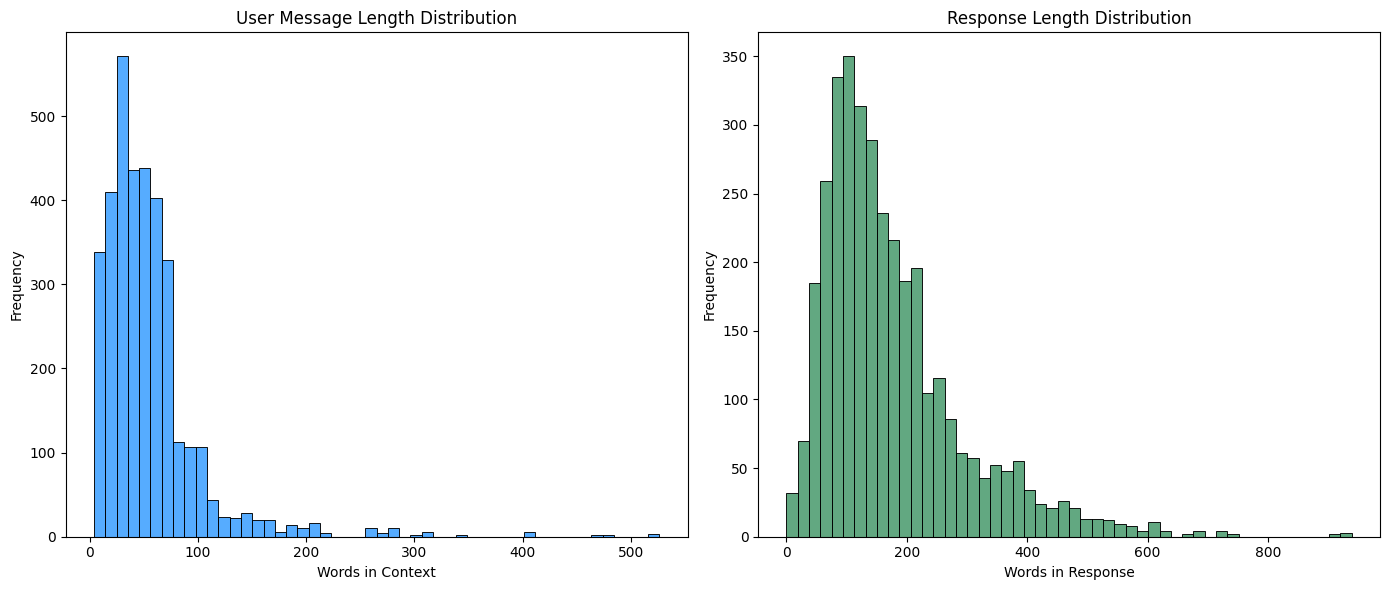

In [13]:
plt.figure(figsize=(14, 6))

# First subplot: Context length
plt.subplot(1, 2, 1)
sns.histplot(df['context_len'], bins=50, color='dodgerblue')
plt.title("User Message Length Distribution")
plt.xlabel("Words in Context")
plt.ylabel("Frequency")

# Second subplot: Response length
plt.subplot(1, 2, 2)
sns.histplot(df['response_len'], bins=50, color='seagreen')
plt.title("Response Length Distribution")
plt.xlabel("Words in Response")
plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig("length_distributions.png")
plt.show()

In [14]:
# Longest messages
print("\nTop 5 longest user inputs:\n", df[['clean_context', 'context_len']].sort_values(by='context_len', ascending=False).head())
print("\nTop 5 longest responses:\n", df[['clean_response', 'response_len']].sort_values(by='response_len', ascending=False).head())

# Short response examples
short_responses = df[df['response_len'] < 10]
print(f"\nFound {len(short_responses)} responses with <10 words (may be low quality).")


Top 5 longest user inputs:
                                           clean_context  context_len
1014  im a teenager and throughout my entire life iv...          526
1643  every once and a while i think about my exboyf...          524
2308  every once and a while i think about my exboyf...          524
2444  my boyfriend and i have been together for five...          478
1023  my boyfriend and i have been together for five...          478

Top 5 longest responses:
                                          clean_response  response_len
815   previous counselors have discussed very good p...           939
897   hello that must be very frustrating for you to...           926
3142  hello that must be very frustrating for you to...           926
3185  i think there are many different directions we...           907
1122  i think there are many different directions we...           907

Found 8 responses with <10 words (may be low quality).


In [15]:
# Filter out short responses
df[df['response_len'] < 10]

,Context,Response,clean_context,clean_response,context_len,response_len
385,I've gone to a couple therapy sessions so far ...,Certainly.,ive gone to a couple therapy sessions so far a...,certainly,30,1
1385,"It's the way my mom said I was worth nothing, ...",There is nothing wrong with going to summer sc...,its the way my mom said i was worth nothing st...,there is nothing wrong with going to summer sc...,21,9
2079,I've gone to a couple therapy sessions so far ...,Certainly.,ive gone to a couple therapy sessions so far a...,certainly,30,1
2624,such as not enough sleep,0,such as not enough sleep,,5,0
2695,Can a counselor take sides with one parent and...,<!--[if gte mso 9]>\n\n\n\n\n\n\n\n\n\n\n\n\n\...,can a counselor take sides with one parent and...,if gte mso \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\...,40,6
3080,"It's the way my mom said I was worth nothing, ...",There is nothing wrong with going to summer sc...,its the way my mom said i was worth nothing st...,there is nothing wrong with going to summer sc...,21,9
3293,I've gone to a couple therapy sessions so far ...,Certainly.,ive gone to a couple therapy sessions so far a...,certainly,30,1
3507,I just took a job that requires me to travel f...,hmm this is a tough one!,i just took a job that requires me to travel f...,hmm this is a tough one,50,6


- The messages from users (or "contexts") are fairly short—around 55 words on average. That’s manageable for tools like LLMs or even traditional models like TF-IDF.
  
- The responses, on the other hand, are much longer—averaging about 177 words. These are great examples to learn from if we’re building models to generate thoughtful advice.


# Check keywords

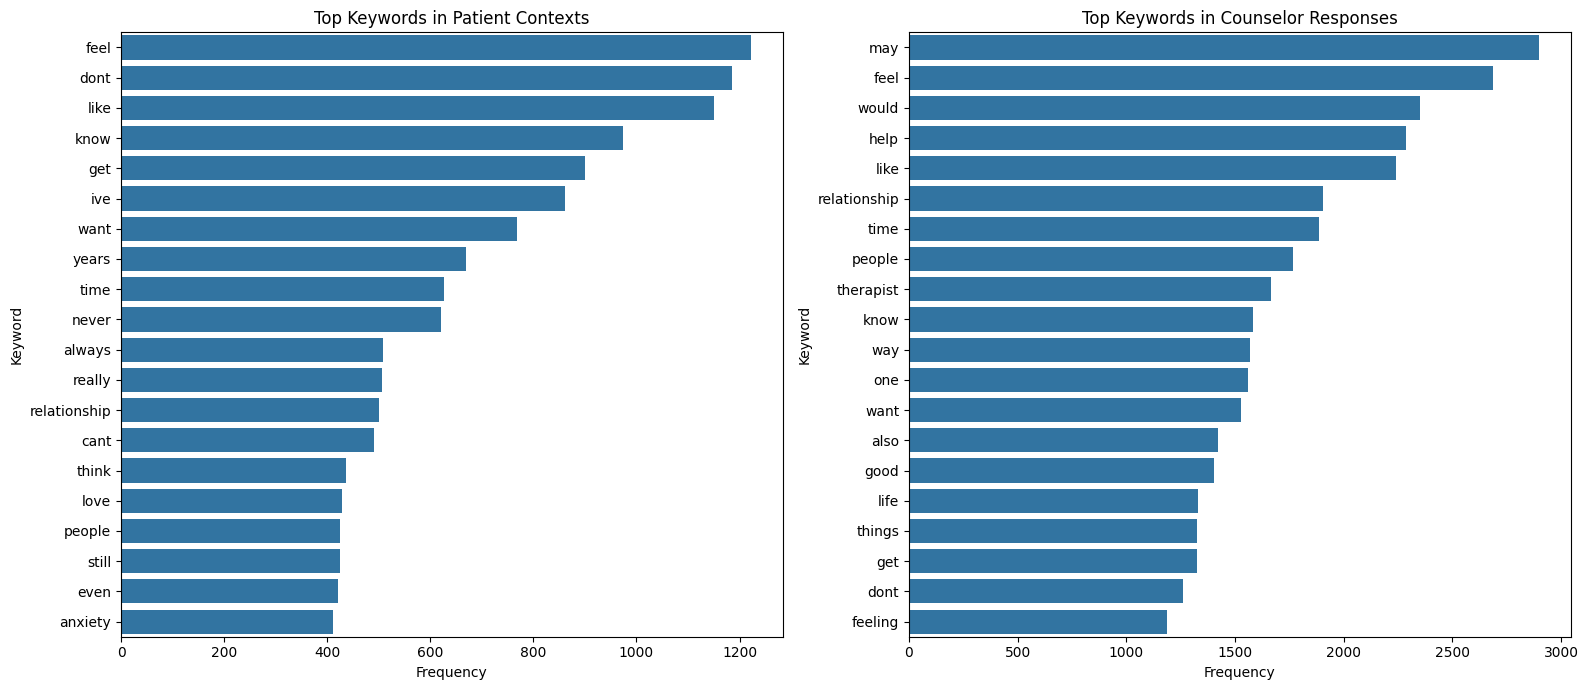

In [16]:
# Function to extract top N keywords from a list of texts
def get_top_keywords(texts, stop_words, top_n=20):
    all_words = ' '.join(texts).split()
    keywords = [word for word in all_words if word.lower() not in stop_words and len(word) > 2]
    return Counter(keywords).most_common(top_n)

# Function to separate keyword-frequency pairs into lists
def unpack_keywords(keyword_freqs):
    keywords, counts = zip(*keyword_freqs)
    return list(keywords), list(counts)

# Function to plot top keywords from two sources side by side
def plot_top_keywords(patient_keywords, response_keywords):
    patient_words, patient_counts = unpack_keywords(patient_keywords)
    response_words, response_counts = unpack_keywords(response_keywords)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Patient Context Keywords
    sns.barplot(x=patient_counts, y=patient_words, ax=axes[0])
    axes[0].set_title("Top Keywords in Patient Contexts")
    axes[0].set_xlabel("Frequency")
    axes[0].set_ylabel("Keyword")

    # Counselor Response Keywords
    sns.barplot(x=response_counts, y=response_words, ax=axes[1])
    axes[1].set_title("Top Keywords in Counselor Responses")
    axes[1].set_xlabel("Frequency")
    axes[1].set_ylabel("Keyword")

    plt.tight_layout()
    plt.savefig("top_keywords.png")
    plt.show()

# Get top keywords from DataFrame columns
top_patient_keywords = get_top_keywords(df['clean_context'], stop_words)
top_response_keywords = get_top_keywords(df['clean_response'], stop_words)

# Plot results
plot_top_keywords(top_patient_keywords, top_response_keywords)


**Frequent keywords**: anxiety, depression, sleep, feel, life, help, stress, alone. These reflect emotional struggles, mental health symptoms, and requests for support.

**Frequent keywords**: therapy, talk, support, understand, important, work, try. This suggests a mix of validation, encouraging professional help, and offering practical strategies.

# 2. Decide on Target Variable

Based on the keywords, we can label our text into 4 catergories: advice, validation, information, and questions. 

- **Advice** is for offering helpful suggestions or next steps. 

- **Validation** is all about showing empathy and letting people know their feelings are normal and okay.

- **Information** responses provide clear, factual content about mental health.

- **Questions** help keep the conversation going by showing curiosity and encouraging users to open up more.



In [17]:
# Function to label responses
def auto_label_response(response):
    response = response.lower()
    for label, keywords in keywords_to_labels.items():
        if any(word in response for word in keywords):
            return label
    return 'information'
    
# Define keyword-based labels
keywords_to_labels = {
    'advice': ['try', 'should', 'suggest', 'recommend'],
    'validation': ['understand', 'feel', 'valid', 'normal'],
    'information': ['cause', 'often', 'disorder', 'symptom'],
    'question': ['how', 'what', 'why', 'have you']
}

# label the response 
df['response_type'] = df['Response'].apply(auto_label_response)

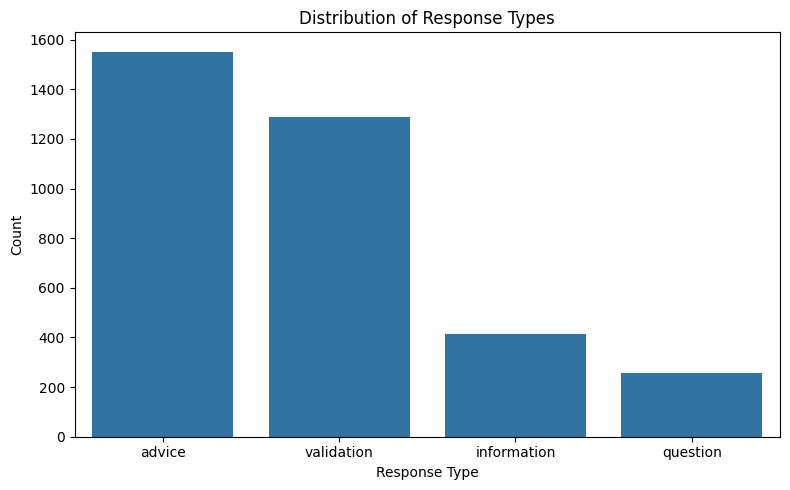

In [18]:
# Count each label
label_counts = df['response_type'].value_counts().reset_index()
label_counts.columns = ['Label', 'Count']

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Label', y='Count', data=label_counts)
plt.title("Distribution of Response Types")
plt.xlabel("Response Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [19]:
df['response_type'].value_counts()

response_type
advice         1552
validation     1287
information     414
question        255
Name: count, dtype: int64

# Build the first baseline ML model -- LogisticRegression

We started by building a simple baseline model to predict the type of response a mental health chatbot should give, using the user's message (context) as input. To do this, we first transformed the text into numerical features using TF-IDF, which captures the importance of words across all messages. Then, we trained a logistic regression model — a straightforward yet effective algorithm for text classification.

We evaluated the model using precision, recall, and F1 scores, and visualized its performance with a confusion matrix and a learning curve. These helped us understand how well the model distinguishes between different types of responses, like advice or validation, and whether it's learning effectively from the data.

Although it's a simple approach, this baseline gives us a solid starting point. 

Classification Report:

              precision    recall  f1-score   support

      advice       0.52      0.69      0.59       306
 information       0.29      0.03      0.05        77
    question       0.50      0.04      0.07        51
  validation       0.53      0.55      0.54       268

    accuracy                           0.52       702
   macro avg       0.46      0.33      0.31       702
weighted avg       0.49      0.52      0.47       702



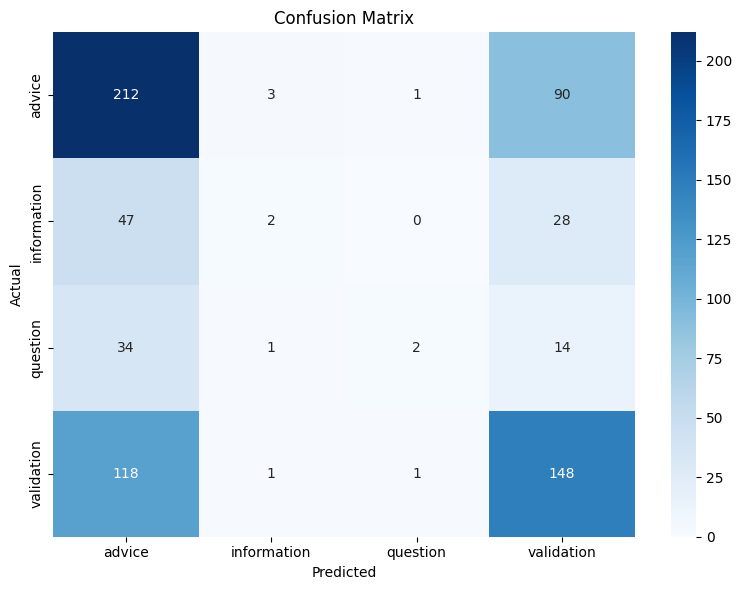


Class Distribution:

response_type
advice         1552
validation     1287
information     414
question        255
Name: count, dtype: int64


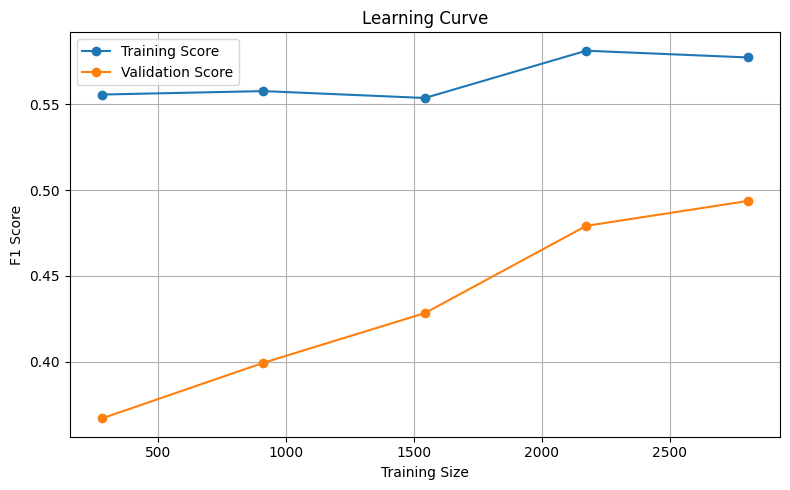

In [20]:
# 1. Vectorize Context column
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['Context'])
y = df['response_type'].values

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. Evaluate model on test data
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# 5. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 6. Show class distribution (do we have enough data?)
print("\nClass Distribution:\n")
print(df['response_type'].value_counts())

# 7. Plot a learning curve to evaluate data efficiency
def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring='f1_weighted',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation Score')
    plt.xlabel("Training Size")
    plt.ylabel("F1 Score")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(model, X, y)


The model achieved an overall accuracy of around 52%, with relatively decent performance on common response types like advice and validation. These categories had F1-scores of 0.59 and 0.54, respectively, meaning the model could identify them fairly well. However, it struggled quite a bit with the information and question categories, where the F1-scores dropped to just 0.05 and 0.07. That’s a clear sign that it has trouble recognizing less frequent or more subtle patterns in the data.

Looking at the confusion matrix, we saw that many responses that were actually validation were often misclassified as advice, and vice versa. This makes sense because those two types of responses often use similar language. Meanwhile, information and question responses were frequently misinterpreted altogether, suggesting the model isn’t picking up on the specific cues that define those categories.

The learning curve tells us something encouraging: the model isn’t overfitting. The validation score improves as more training data is added, which means the model is still learning and might benefit from additional data or a more sophisticated architecture.

One big problem affecting performance is **class imbalance**. Most of our dataset is made up of advice and validation, while information and question responses are relatively rare. This imbalance makes it harder for the model to learn what these underrepresented classes look like.

To improve things, we can try balancing the dataset by either oversampling the smaller classes or undersampling the larger ones. We could also enhance our features by combining both the user's message (Context) and the counselor's response (Response) when training the model. And as we move forward, trying more advanced models—like XGBoost or even a fine-tuned transformer like BERT—could help the model better understand the meaning behind different types of responses.


# Build the second ML model -- XGBoost + TF-IDF

Logistic regression is linear. XGBoost can handle more complex, non-linear relationships. And, XGBooster is still lightweight and interpretable, so we dont have to jump straight to deep learning.

XGBoost Model - Classification Report:

              precision    recall  f1-score   support

      advice       0.56      0.78      0.65       311
 information       0.52      0.14      0.23        83
    question       0.72      0.25      0.38        51
  validation       0.59      0.53      0.56       257

    accuracy                           0.57       702
   macro avg       0.60      0.43      0.45       702
weighted avg       0.58      0.57      0.55       702



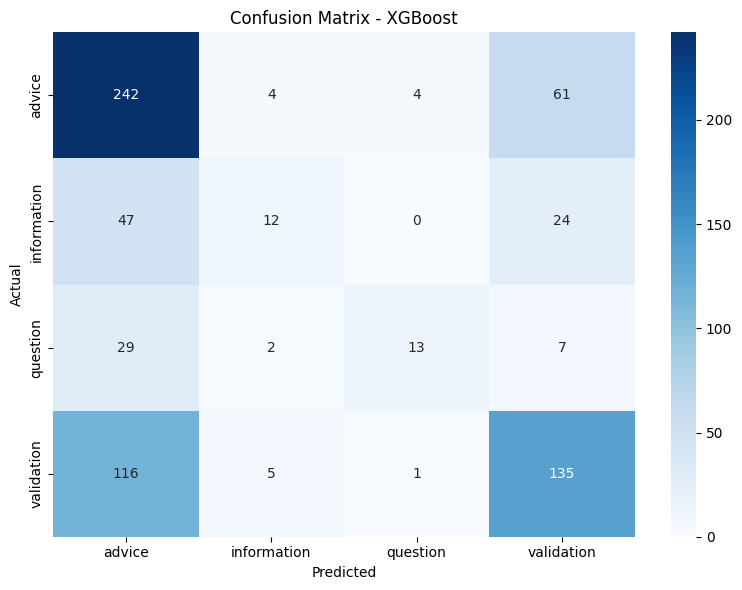

In [21]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['response_type'])

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['Context'])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Train XGBoost
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100
)
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Decode predictions
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# Evaluation
print("XGBoost Model - Classification Report:\n")
print(classification_report(y_test_labels, y_pred_labels))

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


After switching from logistic regression to XGBoost, we saw a noticeable improvement in our model's ability to classify chatbot responses. The overall accuracy rose slightly to 57%, and the F1-score increased to 0.45, suggesting that the model is doing a better job across all categories—not just the most frequent ones.

The model performed particularly well in predicting advice, which had the highest recall (0.78) and an F1-score of 0.65. This makes sense, as advice is the most common response type in the dataset and therefore has more examples for the model to learn from. The validation category also saw solid results, with an F1-score of 0.56, indicating that XGBoost can generally distinguish supportive emotional responses.

However, while there was some improvement, the model still struggled with the underrepresented classes. For instance, it only correctly predicted a small portion of information and question responses. The recall for information was just 0.14, and for question it was 0.25. That means the model often misclassifies these types, possibly because there are fewer examples and they share overlapping language with the more common categories.

The confusion matrix confirms this: many validation responses were still confused with advice, and a significant number of information and question responses were incorrectly labeled as something else. This suggests the model is still relying on surface-level language patterns, and may not yet fully grasp the subtle intent differences between factual responses, emotional support, and follow-up questions.


# Concatenate Context + Response

Right now, we’re only using the Context column. Adding the Response itself or combining both could give the model more clues.


XGBoost with Combined Context+Response - Classification Report:

              precision    recall  f1-score   support

      advice       0.96      0.96      0.96       311
 information       0.92      0.82      0.87        83
    question       0.87      0.76      0.81        51
  validation       0.92      0.97      0.94       257

    accuracy                           0.93       702
   macro avg       0.91      0.88      0.89       702
weighted avg       0.93      0.93      0.93       702



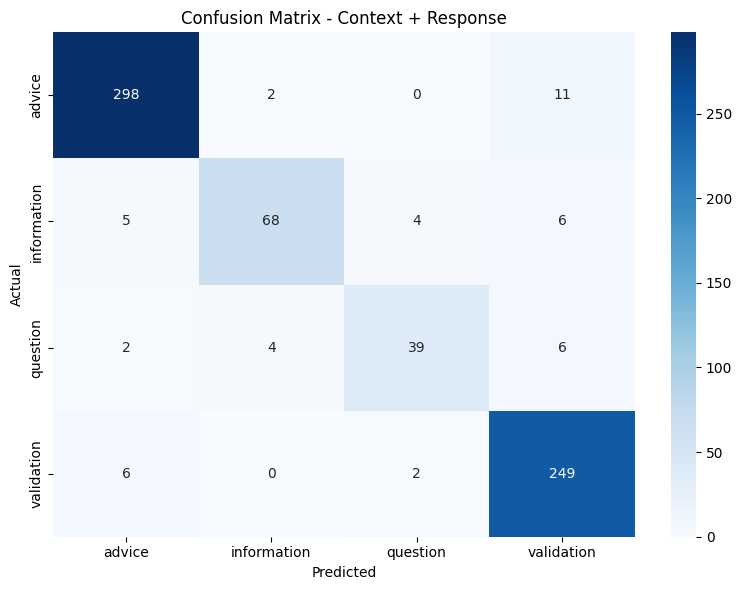

In [22]:
# 1. Combine Context and Response columns
df['combined_text'] = df['Context'] + " " + df['Response']

# 2. Encode labels
le = LabelEncoder()
y = le.fit_transform(df['response_type'])

# 3. TF-IDF Vectorization on combined text
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['combined_text'])

# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5. Train XGBoost Model
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100
)
xgb_model.fit(X_train, y_train)

# 6. Predict
y_pred = xgb_model.predict(X_test)

# 7. Decode predictions
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# 8. Evaluation
print("XGBoost with Combined Context+Response - Classification Report:\n")
print(classification_report(y_test_labels, y_pred_labels))

# 9. Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.title("Confusion Matrix - Context + Response")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


After combining both the user’s message (Context) and the counselor’s reply (Response) into a single input, your model’s performance jumped significantly. Accuracy rose to 93%, and more importantly, the macro-averaged F1-score hit 0.89, which means it's doing consistently well across all classes, even the previously weaker ones like information and question.

The model now handles each response type with impressive precision and recall:
- Advice responses are correctly identified 96% of the time.
- Validation responses, which often get confused with advice, are now classified with 97% recall.
- Even the more challenging categories—Information and Question—saw massive improvements, with F1-scores of 0.87 and 0.81, respectively.
  
The confusion matrix confirms that errors are now minimal and evenly distributed. Misclassifications have become rare, and the model is clearly benefiting from having a fuller view of the dialogue. Giving the model both sides of the conversation—what the user said and how the counselor replied—provided valuable context that helped it understand the tone, purpose, and structure of each response type.


# Sentence-BERT + XGBoost  (Optional*, we could have stopped in the previous step...)

Instead of manually averaging GloVe or Word2Vec vectors, let’s go with SentenceTransformer, which provides pre-trained models that output high-quality sentence embeddings. Here we turn each full Context + Response into a dense vector that captures meaning and intent.


Sentence-BERT + XGBoost

              precision    recall  f1-score   support

      advice       0.77      0.89      0.83       311
 information       0.84      0.67      0.75        83
    question       1.00      0.67      0.80        51
  validation       0.85      0.81      0.83       257

    accuracy                           0.82       702
   macro avg       0.87      0.76      0.80       702
weighted avg       0.83      0.82      0.82       702



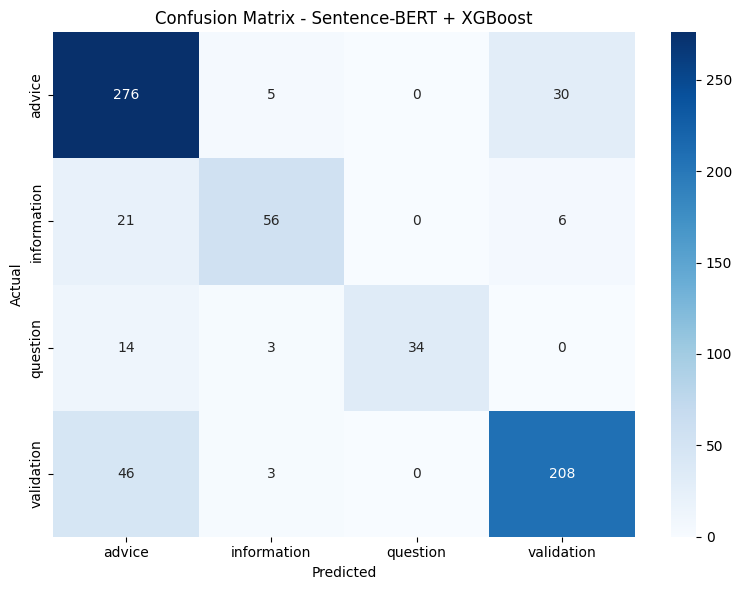

In [23]:
from sentence_transformers import SentenceTransformer


# 1. Combine context and response
df['combined_text'] = df['Context'] + " " + df['Response']

# 2. Encode labels
le = LabelEncoder()
y = le.fit_transform(df['response_type'])

# 3. Sentence-BERT embeddings
embedder = SentenceTransformer('all-MiniLM-L6-v2')
X = embedder.encode(df['combined_text'], show_progress_bar=False)

# 4. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5. Train XGBoost classifier
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100
)
xgb_model.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = xgb_model.predict(X_test)
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

print("Sentence-BERT + XGBoost\n")
print(classification_report(y_test_labels, y_pred_labels))

# 7. Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.title("Confusion Matrix - Sentence-BERT + XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


After switching to Sentence-BERT for semantic embeddings and using XGBoost as the classifier, the model showed a significant jump in understanding across all response types. The overall accuracy reached 82%, with a macro-averaged F1-score of 0.80 — which means it's not just doing well on the most common labels, but it's becoming more fair and consistent across all of them.

For each category:
- Advice: It continues to be strong with an F1 of 0.83, thanks to the large amount of training data.
- Validation: The model now gets it right 81% of the time, with an F1 of 0.83, showing it's learned to distinguish emotional support from guidance.
- Information: It went from being hard to detect to an impressive F1-score of 0.75 — a big leap from earlier models.
- Question: Possibly the biggest win here — the model had 100% precision and a 67% recall, which means when it calls something a question, it’s almost always right.

The confusion matrix shows that misclassifications are fewer and much more evenly spread. Most responses are being classified correctly, and even tricky pairs like advice vs validation are better separated now.